In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("../data400_share/beer.csv", dtype={'review/text' : str})

In [4]:
df.columns

Index(['index', 'beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name',
       'beer/style', 'review/appearance', 'review/aroma', 'review/overall',
       'review/palate', 'review/taste', 'review/text', 'review/timeStruct',
       'review/timeUnix', 'user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix', 'user/gender', 'user/profileName'],
      dtype='object')

In [5]:
df = df[['review/text', 'review/overall']].dropna()
reviews_raw = df['review/text']
y = df['review/overall']

In [6]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
reviews_clean = [REPLACE_NO_SPACE.sub("", row.lower()) for row in reviews_raw]

In [7]:
cv = CountVectorizer(binary=True)
cv.fit(reviews_clean)
X = cv.transform(reviews_clean)
X_test = cv.transform(reviews_clean)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target = [1 if rating > 4 else 0 for rating in y]

X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.75)

for c in np.arange(.01, .1, .01):
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.768270564387
Accuracy for C=0.02: 0.76891070095
Accuracy for C=0.03: 0.768697322095
Accuracy for C=0.04: 0.766883601835
Accuracy for C=0.05: 0.766136775846
Accuracy for C=0.06: 0.767203670116
Accuracy for C=0.07: 0.766030086418
Accuracy for C=0.08: 0.765710018137
Accuracy for C=0.09: 0.764963192148


In [9]:
lr = LogisticRegression(C=.04)
final_model = lr.fit(X, target)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}

for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('exceptional', 0.6515842773570264)
('excellent', 0.62768045856952692)
('fantastic', 0.586556498753527)
('wonderful', 0.54019677290686163)
('highly', 0.52575925545047275)


In [11]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('ok', -0.55554486486160481)
('average', -0.50137814236512179)
('bad', -0.49698303664378896)
('corn', -0.46850466276174679)
('sipper', -0.4434159762682664)


In [13]:
exceptional = [1 if 'exceptional' in r else 0 for r in reviews_clean]
excellent = [1 if 'excellent' in r else 0 for r in reviews_clean]
fantastic = [1 if 'fantastic' in r else 0 for r in reviews_clean]
wonderful = [1 if 'wonderful' in r else 0 for r in reviews_clean]
highly = [1 if 'highly' in r else 0 for r in reviews_clean]

ok = [1 if 'ok' in r else 0 for r in reviews_clean]
average = [1 if 'average' in r else 0 for r in reviews_clean]
bad = [1 if 'bad' in r else 0 for r in reviews_clean]
corn = [1 if 'corn' in r else 0 for r in reviews_clean]
sipper = [1 if 'sipper' in r else 0 for r in reviews_clean]

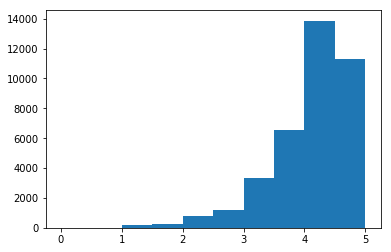

In [14]:
plt.hist(y, bins=10);

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 2)
lda.fit(X)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=2, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [20]:
groups = lda.transform(X)

In [21]:
topics = [1 if g[0] > g[1] else 0 for g in groups]

In [31]:
new = pd.DataFrame(exceptional, columns=['exceptional'])
new['excellent'] = excellent
new['fantastic'] = fantastic
new['wonderful'] = wonderful
new['highly'] = highly

new['ok'] = ok
new['average'] = average
new['bad'] = bad
new['corn'] = corn
new['sipper'] = sipper

new['group_lda'] = topics

new.head()
new.to_csv("sentiments.csv")

In [30]:
group_correctness = pd.DataFrame(topics, columns=['group'])
group_correctness['score'] = y
group1 = np.mean(group_correctness[group_correctness['group'] == 1]['score'])
group0 = np.mean(group_correctness[group_correctness['group'] == 0]['score'])

print("group1: ", group1, "group0: ", group0)

group1:  3.87913158045 group0:  3.89814213654
